In [1]:
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import os
from netCDF4 import Dataset
from data.datasets import RYDLDataset
from neuralop.utils import count_model_params
import h5py
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import torch
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss
from models.fno import FNO
from models.uno import UNO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
batch_size = 4
n_samples = 10 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [4]:
data_dir = "../data/RYDL/"
train_data = RYDLDataset(data_dir, var="train")
val_data = RYDLDataset(data_dir, var="val")

x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(val_loader)

FileNotFoundError: [Errno 2] No such file or directory: '../data/RYDL/train.npy'

In [4]:
# Losses and parameters
l2loss = LpLoss(d=3, p=2, L = L)
energy_score = EnergyScore(d = 3, p = 2, type = "lp", L = L)

# Training parameters
epochs = 5
max_train = 20
max_val = 20
learning_rate = 0.001
dropout_rate = None

In [15]:
model = FNO(n_modes=(4,16, 16), hidden_channels=32, in_channels = 4,
                        dropout=dropout_rate, lifting_channels = 128,
                        projection_channels = 128)
model = model.to(device)

n_params = count_model_params(model)
print(f"\nOur model has {n_params} parameters.")
sys.stdout.flush()


Our model has 4731937 parameters.


In [16]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [19]:
a.shape

torch.Size([4, 4, 8, 228, 170])

In [18]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a[:,:,:,::4,::4].to(device)
        u = u[:,:,:,::4,::4].to(device)

        optimizer.zero_grad()
        out = model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

        if i >= max_train:
            break

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for i,sample in enumerate(val_loader):
            a, u = sample
            a = a[:,:,:,::4,::4].to(device)
            u = u[:,:,:,::4,::4].to(device)

            out = model(a)
            test_l2 += l2loss(out, u).item()

            if i >= max_val:
                break

    train_l2  = train_l2 * batch_size / max_train
    test_l2 = test_l2 * batch_size / max_val
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

KeyboardInterrupt: 

# Plots

In [2]:
map_proj = ccrs.Stereographic(
    true_scale_latitude=60.0, central_latitude=90.0, central_longitude=10.0
)

In [11]:
y_subset = slice(410, -434)
x_subset = slice(159, -485)

xr_test = xr.open_dataset("../data/RYDL/processed/2021/07/YW_2017.002_20210714.nc").isel(y = y_subset, x = x_subset)
prec = np.log(xr_test.isel(time = 220).RR.fillna(0)+0.01)
prec_plot = xr.where(prec< np.log(0.00625+0.01), np.nan, prec)
#prec_plot


In [24]:
data_dir = "../data/RYDL/processed/"
dataset = RYDLDataset(data_dir, var = "val", downscaling_factor=1)
print(len(dataset))

a, u = dataset.__getitem__(10)

2109


In [25]:
a.shape

torch.Size([4, 8, 256, 256])

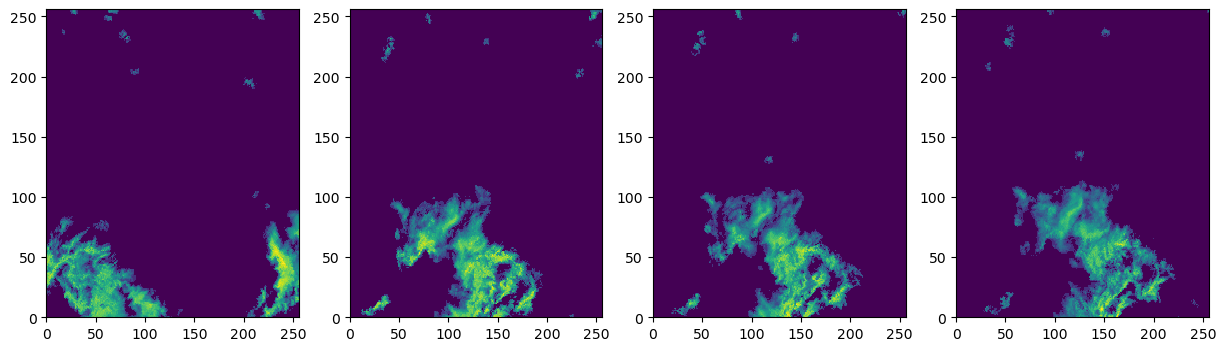

In [26]:
fig, axs = plt.subplots(1,4, figsize = (15,4))
axs[0].pcolormesh(a[0,0])
axs[1].pcolormesh(a[0,-1])  
axs[2].pcolormesh(u[0,0])
axs[3].pcolormesh(u[0,1])

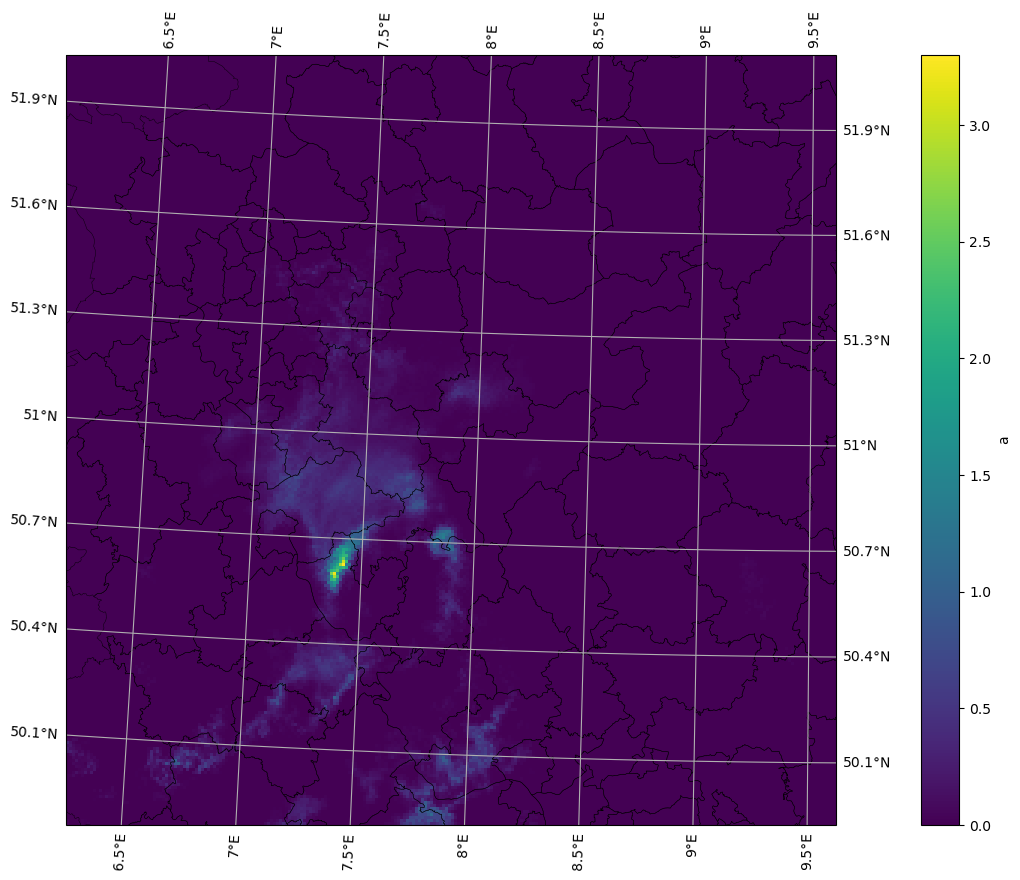

In [34]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': map_proj},figsize=(22,10))
ger_shape = list(shpreader.Reader("../ger_shape/gadm41_DEU_2.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                edgecolor='black', facecolor = "None", lw = 0.3)
val_data.isel(samples = 100, init_steps = 7).a.plot()

#plt.pcolormesh(x*1000,y*1000, train_plot[0,0])
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)


In [ ]:
comp = np.exp(prec)-0.01
comp2 = np.exp(train[0,0].numpy())-0.01

In [ ]:
(comp - comp2).max()

<xarray.DataArray 'RR' ()> Size: 8B
array(5.96046448e-08)
Coordinates:
    time     datetime64[ns] 8B 2021-05-01T14:40:00

In [ ]:
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[3.588929950917963, 14.608702502626649] [46.95258041119031, 54.57904570041962]


In [ ]:
radolan_grid_xy = wrl.georef.get_radolan_grid(1100, 900, wgs84=True)
x = [radolan_grid_xy[0,0,0], radolan_grid_xy[0,-1,0]]
y = [radolan_grid_xy[0,0,1], radolan_grid_xy[-1,0,1]]
print(x,y)

[4.675934176579067, 15.468175240935931] [46.19287861255967, 55.53947933382205]


In [ ]:
xr_test = xr.open_dataset("../data/RYDL/processed/2021/07/YW_2017.002_20210714.nc").isel(y = slice(88,-100), x = slice(135,-85))

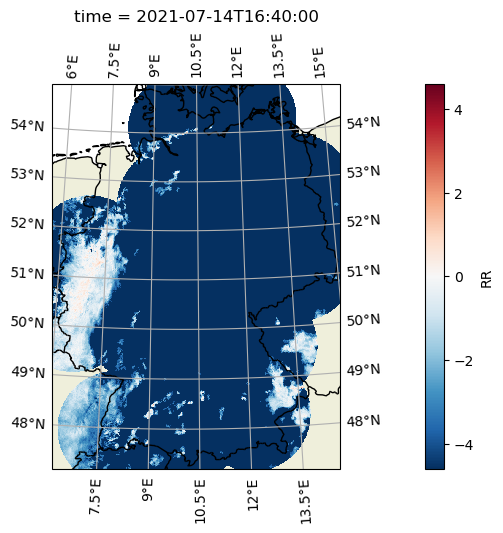

In [ ]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': map_proj},figsize=(22,5))
np.log(xr_test.isel(time = 200).RR+0.01).plot()
ax = plt.gca()
ax.gridlines(draw_labels=True, y_inline=False)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

In [12]:
files = os.listdir("../data/RYDL/processed/2021/07/")
files = ["../data/RYDL/processed/2021/07/" + f for f in files if f.endswith(".nc")]
xr_test = xr.open_mfdataset(files).isel(y = y_subset, x = x_subset)
xr_test.RR

<xarray.DataArray 'RR' (time: 8928, y: 256, x: 256)> Size: 2GB
dask.array<getitem, shape=(8928, 256, 256), dtype=float32, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2kB -2.84e+05 -2.83e+05 ... -2.996e+04 -2.896e+04
  * y        (y) float64 2kB -4.348e+06 -4.347e+06 ... -4.094e+06 -4.093e+06
    lat      (y, x) float64 524kB dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon      (y, x) float64 524kB dask.array<chunksize=(256, 256), meta=np.ndarray>
  * time     (time) datetime64[ns] 71kB 2021-07-01 ... 2021-07-31T23:55:00
Attributes:
    long_name:      5 minute rainfall 
    standard_name:  rainfall_amount
    units:          kg m-2
    grid_mapping:   crs

In [13]:
len(train_data)

12877